# 교차검증 (K-Fold)

## #01. K-Fold 개요

### [1] 머신러닝을 구현하는 과정에서의 대표적 문제점

| 구분 | 설명 |
|---|---|
| 과대적합(Overfitting) | 학습 데이터를 과하게 학습하는 것 |
| 과소적합(Underfitting) | 학습 데이터를 충분히 학습하지 못하는 것 |
| Sample loss 문제 | 학습 데이터가 적은 경우 발생하는 문제<br/>데이터를 Train용과 Test용으로 나누는 과정에서 Train 데이터가 부족해지기 때 문에 발생하는 문제 |

위와 같은 상황에서 학습이 발생시키는 에러를 과소추정하지 않으면서 데이터의 손실
을 최소화하는 방법으로 K-폴드 교차 검증이 있다.

- 과적합을 방지한다.
- 데이터 편향을 방지한다.
- 일반화 된 모델을 생성할 수 있다.

### [2] `K`가 5인 경우에 대한 K-폴드 교차 검증 예시

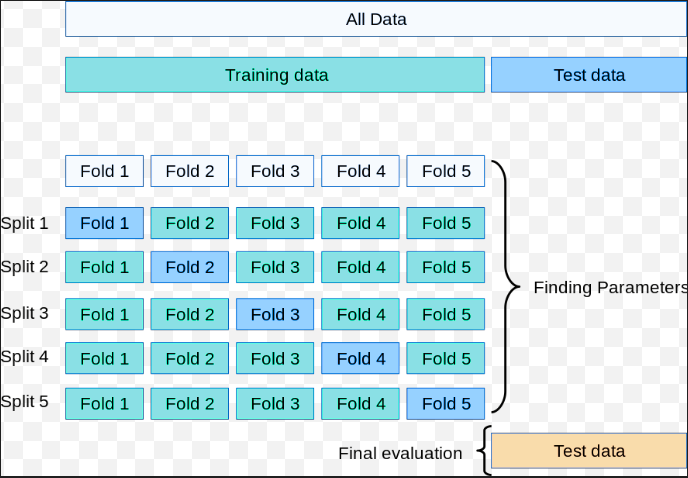

하나의 데이터 셋을 5등분하여 각 Fold마다 한 번씩 Test 데이터가 되도록
train_split을 개별 수행한다.

그 결과 총 5번의 학습이 가능해지며 그 학습 결과에 대한 평균치를 구한다.

## #01. 준비작업

### [1] 패키지 참조

In [2]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(work_path)

from help_a.regression import *
from help_a.util import *
from help_a.plot import *
from help_a.analysis import *

# 선형회귀분석 모듈
from sklearn.linear_model import LinearRegression

# K-Fold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

### [2] 데이터 가져오기

In [3]:
origin = my_read_excel("https://data.hossam.kr/mldata/fish.xlsx", info=False)
my_pretty_table(origin.head())

+----+--------+--------+--------+--------+
|    |   길이 |   높이 |   두께 |   무게 |
|----+--------+--------+--------+--------|
|  0 |    8.4 |   2.11 |   1.41 |    5.9 |
|  1 |   13.7 |   3.53 |      2 |     32 |
|  2 |     15 |   3.82 |   2.43 |     40 |
|  3 |   16.2 |   4.59 |   2.63 |   51.5 |
|  4 |   17.4 |   4.59 |   2.94 |     70 |
+----+--------+--------+--------+--------+


## #03. 데이터 전처리

### [1] 독립변수, 종속변수 분리

In [4]:
yname = '무게'
x = origin.drop(yname, axis=1)
y = origin[yname]
x.shape, y.shape

((56, 3), (56,))

## #04. K-Fold 교차 검증을 적용한 회귀 모델

### [1] 한가지 평가지표만 확인하기

1개의 폴드부터 10개의 폴드 까지 반복적으로 수행

In [5]:
# 최대 폴드 수
k = 10

# 선형회귀분석 모델
model = LinearRegression(n_jobs=-1)

# 각 폴드별 R2
scores = cross_val_score(model, x, y, cv=k, scoring='r2', n_jobs=-1)

print("R2: ", scores)
print("R2 최대값: ", scores.max())
print("R2 최대값의 Fold수: ", scores.argmax()+1)

R2:  [-5.80130229e+01 -2.31476956e+00 -4.52072266e+01 -4.47723355e+00
 -5.35954360e+00 -1.75520025e+01  6.25492054e-01  5.30196516e-01
 -5.03267727e-02 -1.75845285e+01]
R2 최대값:  0.62549205419385
R2 최대값의 Fold수:  7


### [2] 전체 정보 얻기

#### (1) K-Fold 수행

리턴받고자 하는 정보를 bool 형식으로 설정

In [6]:
model = LinearRegression(n_jobs=-1)
result = cross_validate(model, x, y, cv=k, 
                        return_train_score=True, return_estimator=True, 
                        n_jobs=-1) 
result_df = DataFrame(result)
my_pretty_table(result_df)

+----+------------+--------------+-----------------------------+--------------+---------------+
|    |   fit_time |   score_time | estimator                   |   test_score |   train_score |
|----+------------+--------------+-----------------------------+--------------+---------------|
|  0 | 0.00498652 |  0.000999212 | LinearRegression(n_jobs=-1) |      -58.013 |      0.969328 |
|  1 | 0.00298524 |   0.00199389 | LinearRegression(n_jobs=-1) |     -2.31477 |       0.93761 |
|  2 | 0.00299311 |   0.00199461 | LinearRegression(n_jobs=-1) |     -45.2072 |      0.939373 |
|  3 | 0.00598359 |   0.00299239 | LinearRegression(n_jobs=-1) |     -4.47723 |      0.940413 |
|  4 | 0.00398827 |   0.00199556 | LinearRegression(n_jobs=-1) |     -5.35954 |      0.943642 |
|  5 | 0.00398874 |   0.00299573 | LinearRegression(n_jobs=-1) |      -17.552 |      0.948462 |
|  6 | 0.00299215 |   0.00299191 | LinearRegression(n_jobs=-1) |     0.625492 |      0.945635 |
|  7 | 0.00398636 |   0.00199342 | Linea

#### (2) 최적의 성능을 갖는 폴드에 대한 학습 객체 추출

In [7]:
maxindex = result_df['test_score'].argmax()
best_model = result_df.iloc[maxindex]['estimator']
best_model

LinearRegression(n_jobs=-1)

### [3] 최적의 k폴드 수행에 대한 추정치 얻기

In [8]:
y_predict = cross_val_predict(model, x, y, cv=maxindex+1, n_jobs=-1)
y_predict

array([-415.07853167, -226.51199473, -170.5319201 , -102.50092462,
        -68.04456227,   -9.39059305,   -7.16198571,   16.88762632,
         63.61423719,   41.92835141,  139.71780356,  139.54040268,
        147.04399414,  187.58426947,  161.29346999,  134.95737725,
        171.75681189,  155.22220036,  160.06735997,  161.06534327,
        227.92268556,  168.52744392,  116.5759082 ,  199.41972277,
        276.25603007,  221.46559183,  269.52394449,  219.52200383,
        265.68650727,  303.05013887,  447.64446312,  319.07001843,
        312.17502048,  343.23703929,  353.00323619,  372.34359822,
        388.28133524,  641.13625561,  688.40093468,  869.19466922,
        759.52498486,  729.72075358,  728.31303342,  709.7854361 ,
        814.30380312,  744.33044163,  920.9310011 ,  866.73418149,
        754.01238957,  813.11997327,  655.80233646,  749.79587392,
        752.08029315,  795.94389038,  883.27908607,  810.40730325])